# For a given day, plot in situ & satellite fields in the Beaufort Sea

Still in development, use with care!

Kyla Drushka


In [1]:
import os
import s3fs
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pprint import pprint
from pathlib import Path
import h5py
import glob as glob
import pyresample as pr
from pyresample.kd_tree import resample_gauss

In [2]:
# define date and domain of interest
start_date = "2021-09-01T00:00:00"
end_date = "2021-09-01T23:59:59" # one day 
date_range = start_date + "/" + end_date
print(date_range)
# beaufort
lonrange = [-160, -130]
latrange = [68, 80]
bounding_box = (f'{lonrange[0]},{latrange[0]},{lonrange[1]},{latrange[1]}') # make this a string

2021-09-01T00:00:00/2021-09-01T23:59:59


### L3 SMAP SSS. 
Data are on-premesis, so download the file locally

JPL SMAP is better near sea ice, so use that.

note, this requires that the .netrc file includes a PO.DAAC tools password, which is accessed here: https://podaac-tools.jpl.nasa.gov/drive/

machine podaac-tools.jpl.nasa.gov \
login USERNAME\
password YOUR_PW

In [ ]:
concept_id = 'C1650311642-PODAAC' # from earthdatasearch 'C1972955240-PODAAC' is RSS smap
granule_url = 'https://cmr.earthdata.nasa.gov/search/granules'
response = requests.get(granule_url,
                       params={
                           'concept_id': concept_id,
                           'temporal': date_range,  
                           'bounding_box': bounding_box,
                           'page_size': 200,
                       },
                       headers={
                           'Accept': 'application/json'
                       }
                      )
print(response.headers['CMR-Hits']) 

In [ ]:
# create a local downloads folder
os.makedirs("downloads", exist_ok=True)

# download the granules
granules = response.json()['feed']['entry']
for granule in granules:
    url = granule['links'][0]['href']
    id = granule['title']    
    r = requests.get(url)
    outfile = Path('downloads', id)
    if not outfile.exists():
        print(url, id)
        with open(outfile, 'wb') as f:
            f.write(r.content)                     

### L2 SMAP SSS

Also on-premesis. 

Use NRT product (C1972954180-PODAAC), as this notebook is intended to be used during a field campaign.
Delayed-time product is C1972961258-PODAAC


In [21]:
concept_id = 'C1972954180-PODAAC' # from earthdatasearch NRT => doesn't work
concept_id = 'C1972961258-PODAAC' # delayed mode https://search.earthdata.nasa.gov/search/granules?p=C1972961258-PODAAC
granule_url = 'https://cmr.earthdata.nasa.gov/search/granules'
response = requests.get(granule_url,
                       params={
                           'concept_id': concept_id,
                           'temporal': date_range,  
                           'bounding_box': bounding_box,
                           'page_size': 200,
                       },
                       headers={
                           'Accept': 'application/json'
                       }
                      )
print(response.headers['CMR-Hits']) 

10


In [ ]:
# download the granules
# => need this to authenticate with Drive
from requests.auth import HTTPBasicAuth


granules = response.json()['feed']['entry']
for granule in granules:
    #we need to find the 'drive' link for the datafile, assuming the first link[0] is drive is not always correct. sometimes it's opendap.
    for gl in granule['links']:
        print(gl)
        if '/drive/' in gl['href']:
            url = gl['href']
            break
    id = granule['title']
    # Password here is the 'Drive API Password' https://podaac-tools.jpl.nasa.gov/drive/
    # user here is the Earthdata Login username
    r = requests.get(url, auth=HTTPBasicAuth('kdrushka', 'E23UokTDpJs2LtyWcQY'))
    outfile = Path('downloads', id)
    #if not outfile.exists():
    print(url, id)
    with open(outfile, 'wb') as f:
        f.write(r.content)   

In [23]:
h5 = h5py.File(outfile, 'r')
h5.keys() # variable names

<KeysViewHDF5 ['anc_dir', 'anc_spd', 'anc_sss', 'anc_sst', 'anc_swh', 'antazi_aft', 'antazi_fore', 'azi_aft', 'azi_fore', 'ice_concentration', 'inc_aft', 'inc_fore', 'land_fraction_aft', 'land_fraction_fore', 'lat', 'lon', 'n_h_aft', 'n_h_fore', 'n_v_aft', 'n_v_fore', 'nedt_h_aft', 'nedt_h_fore', 'nedt_v_aft', 'nedt_v_fore', 'num_ambiguities', 'quality_flag', 'row_time', 'smap_ambiguity_dir', 'smap_ambiguity_spd', 'smap_high_dir', 'smap_high_dir_smooth', 'smap_high_spd', 'smap_spd', 'smap_sss', 'smap_sss_uncertainty', 'tb_h_aft', 'tb_h_bias_adj', 'tb_h_fore', 'tb_v_aft', 'tb_v_bias_adj', 'tb_v_fore']>

In [ ]:

for granule in granules:
    # local file:
    id = granule['title']
    outfile = Path('downloads', id)
    if outfile.exists():
        # load the file into xarray
        ds = xr.open_mfdataset(outfile, engine='h5netcdf', phony_dims='sort')
        # check if there are lon/lat data in our domain:
        lons = np.reshape(ds.lon.values,[1,-1])
        lats = np.reshape(ds.lat.values,[1,-1])
        sss = np.reshape(ds.smap_sss.values,[1,-1])

        i = ((lons > lonrange[0]) & (lons < lonrange[1]) & (lats > latrange[0]) & (lats < latrange[1])) 
        sss = sss[i]
        # remove nans
        
        if len(sss)>0:
            print(outfile, 'has', len(sss), 'datapoints in our domain')
            plt.scatter(lons,lats,c=sss,vmin=20, vmax=30)

In [28]:
# run through all files, open the file, and check if there are *any* data in our lat/lon rannge
L3files = glob.glob('downloads/RSS_smap_SSS_L3*') # use L3 SMAP - requires having one file stored locally


# loads a single data file ...
ds = xr.open_mfdataset(outfile, engine='h5netcdf', phony_dims='sort')
# phony_dim_0 is swath x, phony_dim_1 is swath y, phony_dim_2 is related to SMAP ambiguity, we can ignore this here
ds = ds.rename_dims({'phony_dim_0':'swath_x', 'phony_dim_1':'swath_y'})

In [156]:
# check if there are lon/lat data in our domain:
lons = np.reshape(ds.lon.values,[1,-1])
lats = np.reshape(ds.lat.values,[1,-1])
sss = np.reshape(ds.smap_sss.values,[1,-1])

i = ((lons > lonrange[0]) & (lons < lonrange[1]) & (lats > latrange[0]) & (lats < latrange[1])) 
sss = sss[i]


array([], dtype=float32)

In [125]:
# follow severine's example to regrid & subsample
L3files = glob.glob('downloads/RSS_smap_SSS_L3*') # use L3 SMAP - requires having one file stored locally
ds_grid = xr.open_dataset(L3files[0])

# define grid lat/lon mesh
longrid = ds_grid.lon.values
latgrid = ds_grid.lat.values
LOgrid, LAgrid = np.meshgrid(longrid, latgrid)
print(LOgrid.shape,LAgrid.shape)

# use pyresample to define a target grid
target = pr.SwathDefinition(LOgrid, LAgrid)

# and the source data
lons = ds.lon.values
lats = ds.lat.values 
source = pr.SwathDefinition(lons, lats)

(720, 1440) (720, 1440)


In [129]:
# resample:
sss = ds.smap_sss.values
result, stddev, counts = resample_gauss(
    source,
    sss,
    target,
    radius_of_influence=175000,  
    sigmas=25000,
    neighbours=100,
    fill_value=np.nan,
    with_uncert=True,
)
result.shape

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 100 neighbours within 175000 m for some data points
  warnings.warn(('Possible more than %s neighbours '


(720, 1440)

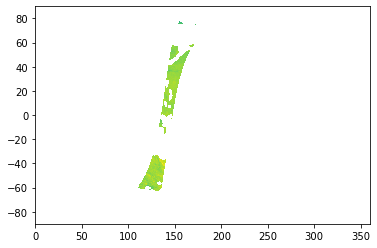

In [133]:
plt.pcolormesh(longrid,latgrid,result)
plt.show()

In [103]:
# find non-nan data:
# sss = ds.smap_sss

# Severuine's code identifies fill value, but the L2 SMAP data doesn't have this field
# - instead, should prob use quality code :/
# attrs = {}
# for k, v in ds.smap_sss.attrs.items():
#         if isinstance(v, bytes):
#             attrs[k] = v.decode('utf-8')
#         else:
#             attrs[k] = v
#         print(k, ' ', attrs[k])
# # attrs['_FillValue']
# sss = numpy.where(ds.smap_sss < attrs['_FillValue'], ds.smap_sss, numpy.nan)
sss = np.where(ds.smap_sss > 0, ds.smap_sss, np.nan)
nnans = ~np.isnan(sss)
sss = sss[nnans]

lons = ds.lon.values[nnans]
lats = ds.lat.values[nnans]  
lons = (lons + 180) % 360 - 180
print(sss.shape, lons.shape, lats.shape)

(41134,) (41134,) (41134,)


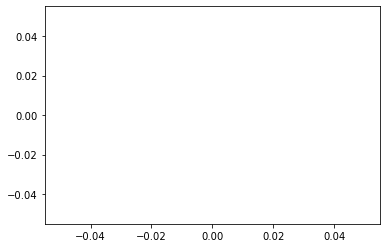

In [123]:
dumx = np.where((ds.lon<lonrange[0], ds.lon>lonrange[1]), ds.lon, np.nan)
dumy = np.where((ds.lat<latrange[0], ds.lat>latrange[1]), ds.lat, np.nan)
# dum = np.where((ds.lon>lonrange[0], ds.lon<lonrange[1]), ds.smap_sss, np.nan)
plt.plot(dumx[0,:,:],dumy[0,:,:],'.')
# dum.shape

plt.show()

In [122]:
lonrange

[-160, -130]

In [65]:
# subset data spatially
# ds.where(ds.lon>lonrange[0] and ds.lat<lonrange[1])
# ds.where(ds.lon>lonrange[0], smap_sss)
# xr.where(ds.lon>lonrange[0], ds.smap_sss, 1).plot()
# ds.lon.plot()
# ds.sel(lon>lonrange[0])

# ideep = ( subsampled_data.dep.values == subsampled_data.dep.values.min() )
# this_var_onedep = sdata[vbl].where(sdata.dep == zpl, drop=True)


i = ( ds.lon.values>lonrange[0] )
plt.plot(ds.lon.sel(

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [59]:


# from pyresample import geometry, geo_filter
lons = np.array([-170, -30, 30, 170])
lats = np.array([20, -40, 50, -80])
swath_def = geometry.SwathDefinition(lons, lats)

data = np.array([1, 2, 3, 4])
filter_area = geometry.AreaDefinition('test', 'test', 'test',
                                      {'proj' : 'eqc', 'lon_0' : 0.0, 'lat_0' : 0.0},
                                      8, 8,
                                      (-20037508.34, -10018754.17, 20037508.34, 10018754.17)
                                     )
filter = np.array([[1, 1, 1, 1, 0, 0, 0, 0],
                   [1, 1, 1, 1, 0, 0, 0, 0],
                   [1, 1, 1, 1, 0, 0, 0, 0],
                   [1, 1, 1, 1, 0, 0, 0, 0],
                   [0, 0, 0, 0, 1, 1, 1, 1],
                   [0, 0, 0, 0, 1, 1, 1, 1],
                   [0, 0, 0, 0, 1, 1, 1, 1],
                   [0, 0, 0, 0, 1, 1, 1, 1],
                  ])
grid_filter = geo_filter.GridFilter(filter_area, filter)
swath_def_filtered, data_filtered = grid_filter.filter(swath_def, data)


/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


In [60]:
swath_def_filtered

In [ ]:


# can we load all data files?




In [ ]:
# === this dopens't work - just use xarray directly
# # Load h5 file
# variable_names = [
#     '/lat',  # length 720
#     '/lon',  # length 1440
#     '/time', # length 1 
#     '/sss_smap' # length 720
#     ]

# with h5py.File(outfile, 'r') as h5:
#     data_vars = {}
#     for varname in variable_names:
#         var = h5[varname]
#         name = varname.split('/')[-1]
#         # Convert attributes
#         attrs = {}
#         for k, v in var.attrs.items():
#             if k != 'DIMENSION_LIST':
#                 if isinstance(v, bytes):
#                     attrs[k] = v.decode('utf-8')
#                 else:
#                     attrs[k] = v
#         data = var[:]
#         if '_FillValue' in attrs:
#             data = np.where(data < attrs['_FillValue'], data, np.nan)
#         # data_vars[name] = (['segment'], data, attrs) # skip adding attrs for now
#         data_vars[name] = (['segment'], data)
#     smap_l2 = xr.Dataset(data_vars)
# smap_l2


In [ ]:
granules

### MODIS SST - from Bia's code, shared/Project1/villasboas_MODIS_SST.ipynb

In [ ]:
provider = 'POCLOUD'
url = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json'
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 300,
                            'temporal': date_range 
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )
response.headers['cmr-hits']

In [ ]:
# Loop through each response in the catalog and print the respective concept ID
# for r in response.json()['items']:
#     print('{} ==> '.format(r['meta']['s3-links'][0].split('/')[1]), r['meta']['concept-id'])

In [ ]:
# Loading credentials for direct access
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

In [ ]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'
response = requests.get(url, 
                        params={
                            'concept_id': 'C2036880650-POCLOUD',
                            'temporal': date_range,
                            'bounding_box': bounding_box, 
                            'page_size': 200,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response)
print(response.headers['CMR-Hits'])

In [ ]:
granules_url = []
for gran in response.json()['feed']['entry']:
    granules_url.append(gran['links'][0]['href'])
granules_url

In [ ]:
# if the same file exists in NRT and non-NRT (ie, DT), skip the NRT version (there is definitely a cleaner way to do this...)
for gran in granules_url:
    if 'NRT' in gran and (gran.rsplit('NRT.nc', 1)[0] + 'nc') in granules_url: # if this has NRT *and* a non-NRT version exists
        granules_url.remove(gran)
print(granules_url)

In [ ]:
def extract_time(ds):
    t0 = np.datetime64(pd.to_datetime(ds.time_coverage_start).date())
    return ds.expand_dims(time=[t0])

In [ ]:
print(granules_url)

In [ ]:
# load file(s)
# use sel and slice to get our region. MODIS SSTs have lat from + to -, so put the bigger lat value first in the slice
file_list =  [fs.open(file) for file in granules_url]
ds_modis = xr.open_mfdataset(file_list, preprocess=extract_time, engine='h5netcdf',concat_dim='time', combine='nested').sel(lon=slice(lonrange[0], lonrange[1]), lat=slice(latrange[1], latrange[0]))
ds_modis


### In situ data from UpTempO buoys

In [ ]:
# for now, just pick a single buoy & download it locally using wget (if new)
buoy_url = 'http://psc.apl.washington.edu/UpTempO/WebDATA/'
buoy_file = 'UpTempO_2019_02_SIZRS-20211117.dat'
buoy_url + buoy_file
!wget -N {buoy_url + buoy_file} -P downloads/

In [ ]:
# for this file, we want to skip the first 35 lines (header). can later generalize this
filename = (f'downloads/{buoy_file}')
f = open(filename,'r')
# data = f.readlines()[35:]
data = f.readlines()[35:40] # start with a small # of rows
f.close()

# %DATA COLUMNS:
# % 0 = year
# % 1 = month
# % 2 = day
# % 3 = hour (GMT)
# % 4 = Latitude (N)
# % 5 = Longitude (E)
# % 6 = Ocean Pressure (dB) at Sensor #1(Nominal Depth = 20.0 m)
# % 7 = Ocean Pressure (dB) at Sensor #2(Nominal Depth = 40.0 m)
# % 8 = Ocean Pressure (dB) at Sensor #3(Nominal Depth = 60.0 m)
# % 9 = Temperature at nominal depth 0.0 (m)
# % 10 = Temperature at nominal depth 2.5 (m)
# % 11 = Temperature at nominal depth 5.0 (m)
# % 12 = Temperature at nominal depth 7.5 (m)
# % 13 = Temperature at nominal depth 10.0 (m)
# % 14 = Temperature at nominal depth 15.0 (m)
# % 15 = Temperature at nominal depth 20.0 (m)
# % 16 = Temperature at nominal depth 25.0 (m)
# % 17 = Temperature at nominal depth 30.0 (m)
# % 18 = Temperature at nominal depth 35.0 (m)
# % 19 = Temperature at nominal depth 40.0 (m)
# % 20 = Temperature at nominal depth 50.0 (m)
# % 21 = Temperature at nominal depth 60.0 (m)
# % 22 = Sea Level Pressure (mBar)
# % 23 = Battery Voltage (V)
# % 24 = Submergence Percent
# 2019 08 14 20.3500 72.013322 -149.817103 0.250 0.431 0.611 13.29 5.022276 3.85962 3.70969 3.468275 3.823188 3.630601 3.738509 3.441308 3.728554 3.573352 3.425621 3.545923 1011.2 12.8 0
# data[[:,1]]

df = pd.read_csv(filename, sep=' ', skiprows=35, names=["year", "month", "day", "hour", "lat", 
                                               "lon", "p20", "p40", "p60", "T0", "T2p5", 
                                               "T5", "T7p5", "T10", "T15", "T20", "T25", 
                                               "T30", "T35", "T40", "T50","T60", "SLP", "voltage", "sub_perc"],
                parse_dates= {"date" : ["year","month","day","hour"]})
df


In [ ]:
# not quite right but close!
# df['dates'] = pd.to_datetime({df['year'],df['month'], df['day']}, format='%Y%m%d')

plt.plot(df['l'],df['T0'])
plt.show()

In [ ]:
df.where(df['T0']!=-999)


# plt.scatter(df['lon'],df['lat'],c=df['T0'],vmin=-5, vmax=5)
# plt.colorbar()

In [ ]:
# identify data from our date range


In [ ]:
# plt.plot(data_vars[lon])
# plt.show()
# attrs['sss_smap']
# smap_l2 = xr.Dataset(data_vars)
# data_vars?

# data_vars (dict-like, optional) – A mapping from variable names to DataArray objects,
# Variable objects or to tuples of the form (dims, data[, attrs]) which can be used as arguments 
# to create a new Variable. Each dimension must have the same length in all variables in which it appears.

# The following notations are accepted:

#     mapping {var name: DataArray}

#     mapping {var name: Variable}

#     mapping {var name: (dimension name, array-like)}

#     mapping {var name: (tuple of dimension names, array-like)}

#     mapping {dimension name: array-like} (it will be automatically moved to coords, see below)

# Each dimension must have the same length in all variables in which it appears.


